In [24]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import pulp

if 'project2' in os.getcwd():
    os.chdir('..')
    
from data.parse import *
from project2.uta.uta import UTA
from project2.uta.uta_plotting import plot_marginal_value_functions, get_ranking
from project2.kendall import *

***
# UTA

In [25]:
UTAresults = UTA()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/Caskroom/miniconda/base/envs/defaultenv/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/cr/q1w72qd12jq54qf_hbc03c180000gn/T/52aeebc98a8148abaac92c751b439fb7-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/cr/q1w72qd12jq54qf_hbc03c180000gn/T/52aeebc98a8148abaac92c751b439fb7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 143 COLUMNS
At line 796 RHS
At line 935 BOUNDS
At line 1002 ENDATA
Problem MODEL has 138 rows, 198 columns and 552 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 89 (-49) rows, 95 (-103) columns and 306 (-246) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 1.0954017e-06 ( 0.00010954017%) - largest zero change 1.0803902e-06
0  Obj 2.0915941e-07 Primal inf 2.02677 (30)
31  Obj 3.9909523e-06 Primal inf 0.142488 (

### UTA 2.1

In [26]:
pairwise_comparisons_UTA

,name1,name2,relation
0,The Godfather,Forrest Gump,better
1,Catwoman,The Prestige,worse
2,Inception,Pulp Fiction,better
3,Batman & Robin,The Dark Knight,worse
4,Whiplash,The Dark Knight,worse
5,Birdemic: Shock and Terror,The Dark Knight,worse
6,Birdemic: Shock and Terror,Inception,worse
7,Jack and Jill,The Dark Knight,worse
8,Jack and Jill,The Godfather,worse
9,Inception,Catwoman,better


In [27]:
for i, hist in enumerate(UTAresults['inconsistent_solution_history']):
    print(f'Iteration {i+1}:')
    print('Inconsistency removed:', hist['true'])
    print('Consistent:', hist['false'])

Iteration 1:
Inconsistency removed: ['Slack_Catwoman_The_Dark_Knight_better', 'Slack_The_Dark_Knight_The_Prestige_better', 'Slack_The_Room_Battlefield_Earth_better']
Consistent: ['Slack_Batman_&_Robin_The_Dark_Knight_worse', 'Slack_Battlefield_Earth_Fifty_Shades_of_Grey_worse', 'Slack_Birdemic:_Shock_and_Terror_Inception_worse', 'Slack_Birdemic:_Shock_and_Terror_The_Dark_Knight_worse', 'Slack_Catwoman_Jack_and_Jill_worse', 'Slack_Catwoman_The_Prestige_worse', 'Slack_Dune_2_The_Godfather_better', 'Slack_Fifty_Shades_of_Grey_Forrest_Gump_worse', 'Slack_Forrest_Gump_The_Godfather_worse', 'Slack_Gladiator_Forrest_Gump_better', 'Slack_Inception_Catwoman_better', 'Slack_Inception_Gladiator_better', 'Slack_Inception_Pulp_Fiction_better', 'Slack_Jack_and_Jill_The_Dark_Knight_worse', 'Slack_Jack_and_Jill_The_Godfather_worse', 'Slack_Se7en_The_Godfather_better', 'Slack_Shutter_Island_The_Godfather_better', 'Slack_The_Departed_Inception_worse', 'Slack_The_Godfather_Forrest_Gump_better', 'Slack_Th

`Discuss the results: [TODO]`

### UTA 2.2

In [28]:
# Inconsistency that was removed:
UTAresults['final_inconsistency_removed']['true']

['Slack_Catwoman_The_Dark_Knight_better',
 'Slack_The_Dark_Knight_The_Prestige_better',
 'Slack_The_Room_Battlefield_Earth_better']

In [29]:
problem: pulp.LpProblem = UTAresults['final_pulp_problem']

In [30]:
# List all variables and their values
for v in problem.variables():
    print(v.name, '=', v.varValue)

Acting1 = 0.0
Acting10 = 0.18
Acting2 = 0.0
Acting3 = 0.0
Acting4 = 0.0
Acting5 = 0.0
Acting6 = 0.0
Acting7 = 0.0
Acting8 = 0.0352
Acting9 = 0.0352
Batman_&_Robin = 0.0351
Battlefield_Earth = 0.07
Birdemic:_Shock_and_Terror = 0.07
Catwoman = 0.035
Critics_Score1 = 0.0
Critics_Score10 = 0.5
Critics_Score2 = 0.0
Critics_Score3 = 0.0
Critics_Score4 = 0.0
Critics_Score5 = 0.0
Critics_Score6 = 0.0
Critics_Score7 = 0.0
Critics_Score8 = 0.0
Critics_Score9 = 0.0
Dune_2 = 0.2852
Fifty_Shades_of_Grey = 0.0701
Fight_Club = 0.3949
Foodfight! = 0.07
Forrest_Gump = 0.0702
Gigli = 0.07
Gladiator = 0.2501
Goodfellas = 0.25
Inception = 0.2502
Jack_and_Jill = 0.07
Music1 = 0.0
Music2 = 0.0
Music3 = 0.0001
Music4 = 0.035
Music5 = 0.035
Oscars_Won0 = 0.0
Oscars_Won1 = 0.0
Oscars_Won10 = 0.0
Oscars_Won11 = 0.0
Oscars_Won12 = 0.0
Oscars_Won13 = 0.0
Oscars_Won14 = 0.0
Oscars_Won15 = 0.0
Oscars_Won16 = 0.0
Oscars_Won17 = 0.0
Oscars_Won18 = 0.0
Oscars_Won19 = 0.0
Oscars_Won2 = 0.0
Oscars_Won20 = 0.0
Oscars_Won

In [31]:
# Print all constraints
print('Constraints:')
for c in problem.constraints:
    print(problem.constraints[c])

Constraints:
Acting1 - Acting2 <= 0
Acting2 - Acting3 <= 0
Acting3 - Acting4 <= 0
Acting4 - Acting5 <= 0
Acting5 - Acting6 <= 0
Acting6 - Acting7 <= 0
Acting7 - Acting8 <= 0
Acting8 - Acting9 <= 0
-Acting10 + Acting9 <= 0
Plot1 - Plot2 <= 0
Plot2 - Plot3 <= 0
Plot3 - Plot4 <= 0
Plot4 - Plot5 <= 0
Pictures1 - Pictures2 <= 0
Pictures2 - Pictures3 <= 0
Pictures3 - Pictures4 <= 0
Pictures4 - Pictures5 <= 0
Pictures5 - Pictures6 <= 0
Pictures6 - Pictures7 <= 0
Pictures7 - Pictures8 <= 0
Pictures8 - Pictures9 <= 0
-Pictures10 + Pictures9 <= 0
Music1 - Music2 <= 0
Music2 - Music3 <= 0
Music3 - Music4 <= 0
Music4 - Music5 <= 0
Sentiment0 - Sentiment1 <= 0
Critics_Score1 - Critics_Score2 <= 0
Critics_Score2 - Critics_Score3 <= 0
Critics_Score3 - Critics_Score4 <= 0
Critics_Score4 - Critics_Score5 <= 0
Critics_Score5 - Critics_Score6 <= 0
Critics_Score6 - Critics_Score7 <= 0
Critics_Score7 - Critics_Score8 <= 0
Critics_Score8 - Critics_Score9 <= 0
-Critics_Score10 + Critics_Score9 <= 0
Oscars_Wo

In [32]:
# Print the equation
print('Objective function:')
print(problem.objective)

Objective function:
OverEstimationError_Batman_&_Robin(in_comp_Batman_&_Robin_The_Dark_Knight_3_) + OverEstimationError_Battlefield_Earth(in_comp_Battlefield_Earth_Fifty_Shades_of_Grey_22_) + OverEstimationError_Birdemic:_Shock_and_Terror(in_comp_Birdemic:_Shock_and_Terror_Inception_6_) + OverEstimationError_Birdemic:_Shock_and_Terror(in_comp_Birdemic:_Shock_and_Terror_The_Dark_Knight_5_) + OverEstimationError_Catwoman(in_comp_Catwoman_Jack_and_Jill_21_) + OverEstimationError_Catwoman(in_comp_Catwoman_The_Prestige_1_) + OverEstimationError_Catwoman(in_comp_Inception_Catwoman_9_) + OverEstimationError_Dune_2(in_comp_Dune_2_The_Godfather_14_) + OverEstimationError_Fifty_Shades_of_Grey(in_comp_Battlefield_Earth_Fifty_Shades_of_Grey_22_) + OverEstimationError_Fifty_Shades_of_Grey(in_comp_Fifty_Shades_of_Grey_Forrest_Gump_15_) + OverEstimationError_Forrest_Gump(in_comp_Fifty_Shades_of_Grey_Forrest_Gump_15_) + OverEstimationError_Forrest_Gump(in_comp_Forrest_Gump_The_Godfather_13_) + OverEst

In [33]:
# 2.2 Final Objective value 
UTAresults['final_objective_value']

0.0

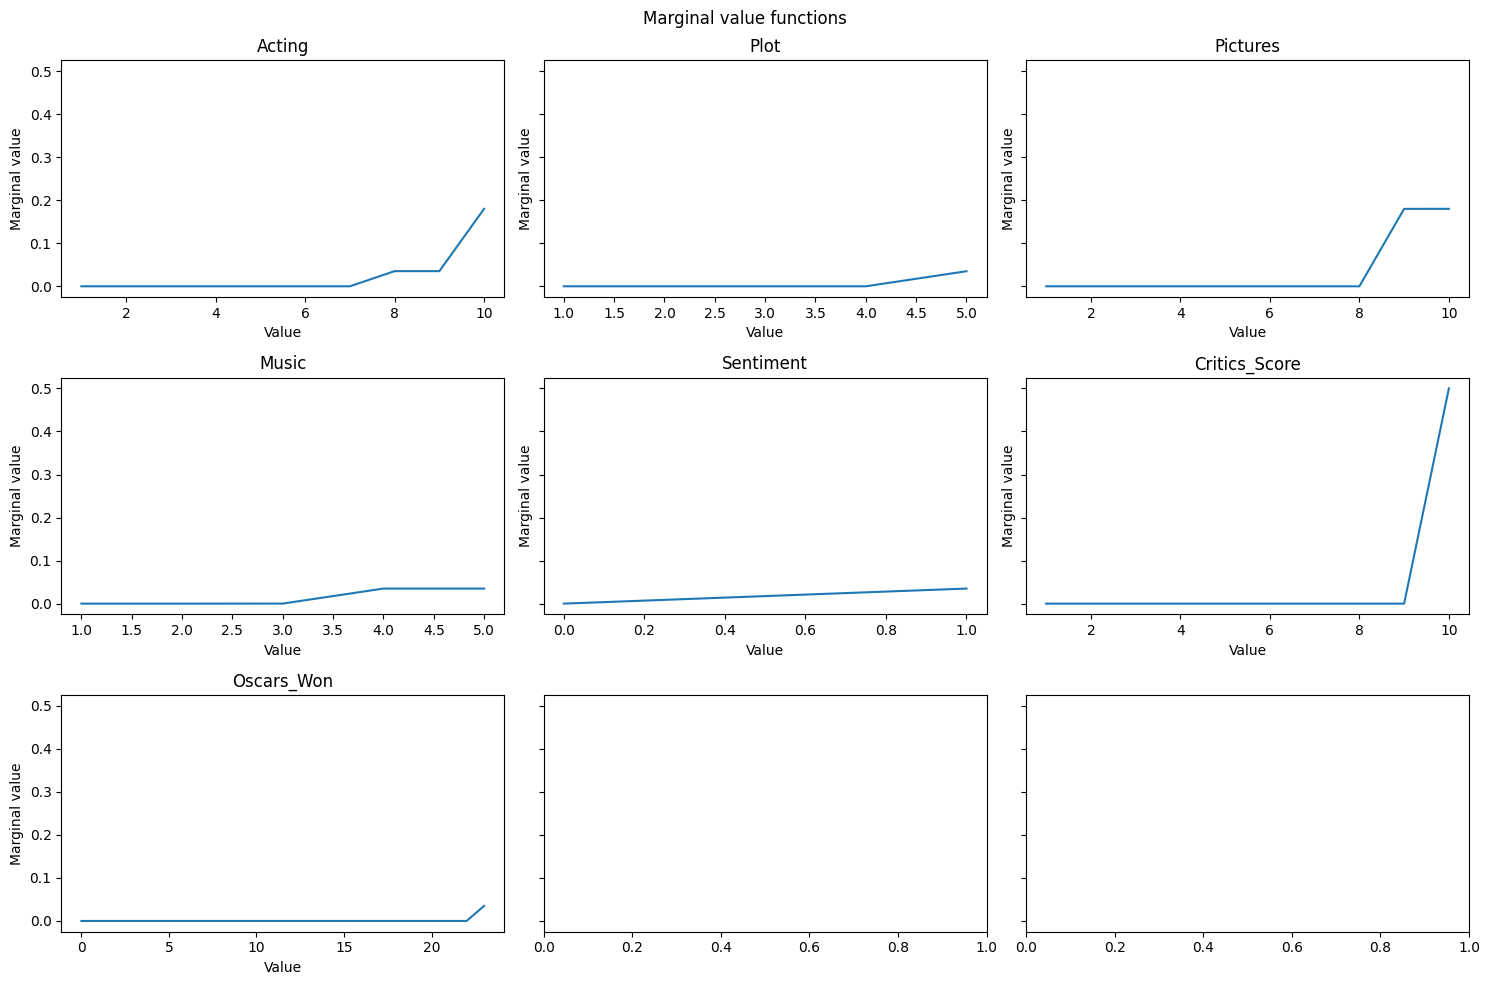

In [34]:
plot_marginal_value_functions(UTAresults, criteria, data)

In [35]:
uta_ranking = get_ranking(UTAresults, data)
uta_ranking

[('The_Prestige', 0.4299),
 ('Fight_Club', 0.3949),
 ('Shutter_Island', 0.3201),
 ('The_Lord_of_the_Rings:_The_Return_of_the_King', 0.2852),
 ('Dune_2', 0.2852),
 ('Se7en', 0.285),
 ('Inception', 0.2502),
 ('The_Dark_Knight', 0.2501),
 ('Gladiator', 0.2501),
 ('The_Godfather', 0.25),
 ("Schindler's_List", 0.25),
 ('Whiplash', 0.25),
 ('The_Godfather_Part_II', 0.25),
 ('The_Silence_of_the_Lambs', 0.25),
 ('Goodfellas', 0.25),
 ('The_Shawshank_Redemption', 0.1052),
 ('Pulp_Fiction', 0.1052),
 ('The_Green_Mile', 0.1052),
 ('The_Departed', 0.1052),
 ('Forrest_Gump', 0.0702),
 ('The_Matrix', 0.0702),
 ('Fifty_Shades_of_Grey', 0.0701),
 ('Transformers:_Revenge_of_the_Fallen', 0.0701),
 ('Gigli', 0.07),
 ('The_Room', 0.07),
 ('Jack_and_Jill', 0.07),
 ('Birdemic:_Shock_and_Terror', 0.07),
 ('Battlefield_Earth', 0.07),
 ('Superbabies:_Baby_Geniuses_2', 0.07),
 ('Foodfight!', 0.07),
 ('Batman_&_Robin', 0.0351),
 ('Catwoman', 0.035)]

In [36]:
calulate_kendall_matrix(uta_ranking, pretty_print=True)

,Catwoman,Batman_&_Robin,Gigli,The_Room,Jack_and_Jill,Birdemic:_Shock_and_Terror,Battlefield_Earth,Superbabies:_Baby_Geniuses_2,Foodfight!,Fifty_Shades_of_Grey,...,Goodfellas,The_Dark_Knight,Gladiator,Inception,Se7en,The_Lord_of_the_Rings:_The_Return_of_the_King,Dune_2,Shutter_Island,Fight_Club,The_Prestige
Catwoman,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Batman_&_Robin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gigli,0.0,0.0,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The_Room,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jack_and_Jill,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Birdemic:_Shock_and_Terror,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Battlefield_Earth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Superbabies:_Baby_Geniuses_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Foodfight!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fifty_Shades_of_Grey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***
# AHP

In [37]:
tree_df = pd.read_csv('data/ahp/hierarchy.csv')
hierarchy_directory = 'data/ahp/'
data_df = pd.read_csv('data/data.csv')
from project2.ahp.ahp import *

## Criteria hierarchy

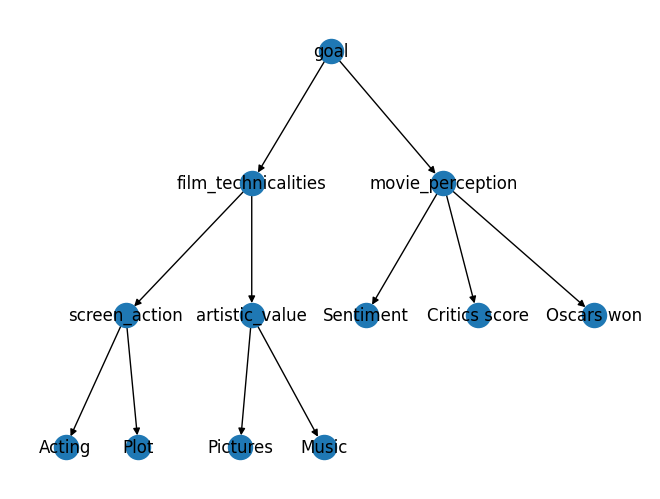

In [38]:
plot_tree(tree_df)

In [39]:
loaded_matrices = load_comparison_matrices(hierarchy_directory)
eigenvectors = {}
for node, matrix in loaded_matrices.items():
    eigenvectors[node] = approximate_principal_eigenvector(matrix.values)

## Tree with calculated weightss

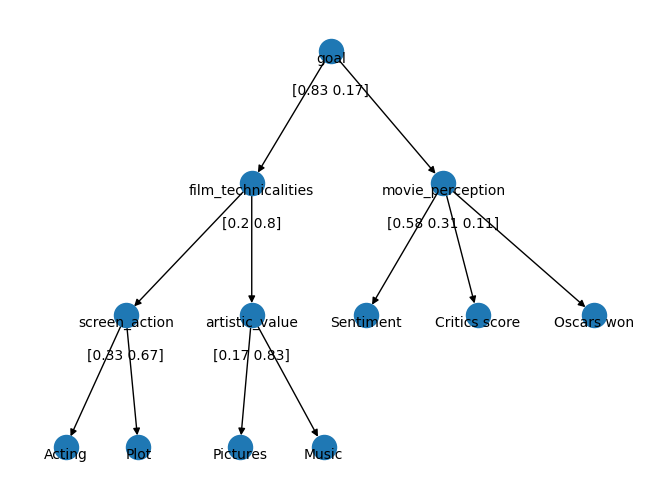

In [40]:
plot_tree_with_weights(tree_df, eigenvectors)

## Comparison matrices & Relative Consistency Indices

In [41]:
for node, matrix in loaded_matrices.items():
    print(node)
    cr = calculate_consistency_ratio(matrix)
    print(f"Relative consistency index: {cr}")
    ans = "Satisfactory" if cr < 0.1 else "Unsatisfactory"
    print(f"Consistency: {ans}")
    print(matrix)
    print()

goal_comparison
Relative consistency index: 0.0
Consistency: Satisfactory
   film_technicalities  movie_perception
0                  1.0               5.0
1                  0.2               1.0

movie_perception_comparison
Relative consistency index: (0.0029145591970559316+0j)
Consistency: Satisfactory
   Sentiment  Critics Score  Oscars Won
0        1.0          2.000         5.0
1        0.5          1.000         3.0
2        0.2          0.333         1.0

screen_action_comparison
Relative consistency index: 0.0
Consistency: Satisfactory
   Acting  Plot
0     1.0   0.5
1     2.0   1.0

film_technicalities_comparison
Relative consistency index: 0.0
Consistency: Satisfactory
   screen_action  artistic_value
0            1.0            0.25
1            4.0            1.00

artistic_value_comparison
Relative consistency index: 0.0
Consistency: Satisfactory
   Pictures  Music
0       1.0    0.2
1       5.0    1.0



We did not perform pairwise comparisons between alternatives for each leaf criteria (lowest level criteria) because we would for each one of those have large comparison matrices (7 criteria, 33x33). Instead, we treated them as quantitative criteria and calculated their weights directly. 

The method was suggested at our Decision Analysis lectures at the slide visible below:

![](quantitative_info_slide.png)

In our opinion this is much more convinient approach for decisionmakers, as they do not have to perform large amounts of comparisons which would be exhausting and keeping them consistend would be hard. Instead, because we had quantitative evaluations from previous project, we went with this approach.

## Dealing with inconsistency

As stated in the project description, we provided one inconsistent comparison matrix in our problem. This matrix was comparion of movie_perception children which are:
- Sentiment
- Critics score
- Oscars won

In [42]:
inconsistent_matrix = loaded_matrices['movie_perception_comparison']
inconsistent_matrix

,Sentiment,Critics Score,Oscars Won
0,1.0,2.000,5.0
1,0.5,1.000,3.0
2,0.2,0.333,1.0


Here we calculated the principal eigenvector with the power method:

In [43]:
inconsistent_matrix_weights = approximate_principal_eigenvector(inconsistent_matrix.values)
inconsistent_matrix_weights

array([0.58157465, 0.30900373, 0.10942162])

Given those weights, we recreated the original matrix A:

In [44]:
recreated_matrix = recreate_matrix_from_weights(inconsistent_matrix_weights)
recreated_matrix

array([[1.        , 1.88209588, 5.31498872],
       [0.53132256, 1.        , 2.82397341],
       [0.18814715, 0.35411098, 1.        ]])

And compared it with the matrix provided by DM:

In [45]:
differece_matrix = inconsistent_matrix - recreated_matrix
differece_matrix

,Sentiment,Critics Score,Oscars Won
0,0.000000,0.117904,-0.314989
1,-0.031323,0.000000,0.176027
2,0.011853,-0.021111,0.000000


We can see that the largest difference between the matrices is between how much times the Sentiment is better than Oscars won (-0.31).

## Final ranking obtained from AHP

In [46]:
perform_ahp(data_df, loaded_matrices, tree_df)

/Users/michalwilinski/Work/politechnika/decision-analysis/project2/ahp/ahp.py:171: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  criterion_score = row[i]


[('The Lord of the Rings: The Return of the King', 0.228525881785606),
 ("Schindler's List", 0.1716782997998768),
 ('The Shawshank Redemption', 0.17142462146400672),
 ('The Godfather Part II', 0.16356588490780094),
 ('Forrest Gump', 0.15189254706828356),
 ('The Silence of the Lambs', 0.14556402493702902),
 ('Gladiator', 0.14018314535888185),
 ('Inception', 0.13262628602236148),
 ('The Matrix', 0.13151517491125037),
 ('The Green Mile', 0.1277817358522092),
 ('The Departed', 0.1277817358522092),
 ('The Godfather', 0.12510434644626245),
 ('Whiplash', 0.1245487908907069),
 ('The Prestige', 0.10765804203104612),
 ('The Dark Knight', 0.10642970482578029),
 ('Goodfellas', 0.09890776524968126),
 ('Fight Club', 0.09386287034113759),
 ('Pulp Fiction', 0.09347273976355207),
 ('Shutter Island', 0.07705524012571346),
 ('Se7en', 0.07675336290602802),
 ('Dune 2', 0.07590920925418101),
 ('Batman & Robin', 0.042240075874965685),
 ('Catwoman', 0.04092943233596645),
 ('Fifty Shades of Grey', 0.0340453546

***
# Comparison

In [47]:
promethee_ranking = [(x,y) for x, y in list(pd.read_csv('results/promethee/ranking_prom2_overall.csv').to_numpy())]
promethee_ranking

[('Birdemic: Shock and Terror', 18.43181818181818),
 ('The Room', 18.43181818181818),
 ('Foodfight!', 18.43181818181818),
 ('Superbabies: Baby Geniuses 2', 18.227272727272727),
 ('Gigli', 16.772727272727273),
 ('Catwoman', 16.31818181818182),
 ('Jack and Jill', 16.295454545454547),
 ('Battlefield Earth', 16.295454545454547),
 ('Transformers: Revenge of the Fallen', 13.931818181818183),
 ('Fifty Shades of Grey', 13.931818181818183),
 ('Batman & Robin', 12.863636363636363),
 ('Shutter Island', -3.772727272727273),
 ('Se7en', -3.772727272727273),
 ('Goodfellas', -4.340909090909092),
 ('Pulp Fiction', -4.340909090909092),
 ('Fight Club', -4.613636363636363),
 ('Dune 2', -4.977272727272728),
 ('The Dark Knight', -5.5227272727272725),
 ('The Prestige', -5.863636363636363),
 ('Whiplash', -8.431818181818183),
 ('The Godfather', -9.045454545454549),
 ('The Departed', -9.90909090909091),
 ('The Green Mile', -9.90909090909091),
 ('The Matrix', -10.295454545454543),
 ('Forrest Gump', -10.318181818

In [48]:
compute_kendalls_tau(uta_ranking, promethee_ranking)

0.9506048387096774